# Introduction

**Objective**<br>
* Build model for cutomer segmentation from the [Retail_Transaction_Data | Kaggle](https://www.kaggle.com/regivm/retailtransactiondata?select=Retail_Data_Response.csv)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from IPython.display import Image
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn import over_sampling
from sklearn.cluster import KMeans, k_means, AgglomerativeClustering
from sklearn.decomposition import PCA

#sns.set(rc={'figure.figsize':(16,8)})
#sns.set_style("whitegrid")
#sns.color_palette("dark")
#plt.style.use("fivethirtyeight")

# Load & Describe Data

## Load Data

In [2]:
data = pd.read_csv("Retail_Data_Transactions.csv")
print("Toal Rows: ", data.shape[0])
print("Total Features: ", data.shape[1])
data.head(5)

Toal Rows:  125000
Total Features:  3


,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


## Data Description

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


## Check Null / Missing Value and Duplicated Rows

In [4]:
data.isnull().sum()

customer_id    0
trans_date     0
tran_amount    0
dtype: int64

In [5]:
data.duplicated().sum()

6

## Numerical Data

**Assign the numerical data into `data_num` object**

In [6]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(data.select_dtypes(include = numerics).columns)
print(data.select_dtypes(include=numerics).shape)
data_num = data.select_dtypes(include=numerics)
data_num.head()

Index(['tran_amount'], dtype='object')

(125000, 1)


,tran_amount
0,35
1,39
2,52
3,99
4,78


## Categorical Data

**Assign the categorical data into `data_cat` object**

In [7]:
display(data.select_dtypes(include=["object"]).columns)
print(data.select_dtypes(include=object).shape)
data_cat = data.select_dtypes(include=["object"])
data_cat.head()

Index(['customer_id', 'trans_date'], dtype='object')

(125000, 2)


,customer_id,trans_date
0,CS5295,11-Feb-13
1,CS4768,15-Mar-15
2,CS2122,26-Feb-13
3,CS1217,16-Nov-11
4,CS1850,20-Nov-13


* From the data, we have 125000 rows with 3 features, 2 as the categorical and 1 as the numerical feature.
* The data is clean enough, there are no null or missing value. But we have 6 duplicated rows.
* While the `trans_date` contains date information with the string type, we have to convert this to the right format date for the next preparation.

# Data Preparation

## Handle Duplicated Rows

In [8]:
data.duplicated().sum()

6

In [9]:
data = data.drop_duplicates()

In [10]:
data.duplicated().sum()

0

## Converts The `trans_date` into Date Time Format

**As the `trans_date` not in the right data type as the datetime, we have to convert it for the next purpose, especially for the RFM's featuring process**

In [11]:
print(type(data["trans_date"]))

<class 'pandas.core.series.Series'>


In [12]:
data["trans_date"] = pd.to_datetime(data["trans_date"])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124994 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  124994 non-null  object        
 1   trans_date   124994 non-null  datetime64[ns]
 2   tran_amount  124994 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.8+ MB


In [14]:
data.describe()

,tran_amount
count,124994.000000
mean,64.992504
std,22.859952
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


## Create RFM Features

### Recency

In [15]:
# Create new dataframe drfm based on unique customer_id
drfm = pd.DataFrame(data["customer_id"].unique())
drfm.columns = ["customer_id"]
drfm

,customer_id
0,CS5295
1,CS4768
2,CS2122
3,CS1217
4,CS1850
...,...
6884,CS8478
6885,CS8326
6886,CS8409
6887,CS8479


In [16]:
# Groupby customer_id and aggregate the trans_date to see the trans_date for each customer_id
recency = data.groupby(["customer_id"]).agg({
    "trans_date": ['max']
}).reset_index()
recency.columns = ["customer_id", "trans_date"]

In [17]:
# last_trans to see the date of last transaction using max() function
last_trans = max(recency["trans_date"])
last_trans

Timestamp('2015-03-16 00:00:00')

In [18]:
# add new columns contains information of the recency days by subtracting last transactions for each customer_id from the trans_date
recency['recency'] = (last_trans - recency['trans_date']).dt.days
recency

,customer_id,trans_date,recency
0,CS1112,2015-01-14,61
1,CS1113,2015-02-09,35
2,CS1114,2015-02-12,32
3,CS1115,2015-03-05,11
4,CS1116,2014-08-25,203
...,...,...,...
6884,CS8996,2014-12-09,97
6885,CS8997,2014-06-28,261
6886,CS8998,2014-12-22,84
6887,CS8999,2014-07-02,257


In [19]:
# Merge the recency to drfm dataframe
drfm = pd.merge(drfm, recency[["customer_id", "recency"]], on="customer_id")
drfm.head()

,customer_id,recency
0,CS5295,111
1,CS4768,1
2,CS2122,21
3,CS1217,77
4,CS1850,7


### Frequency

In [20]:
frequency = data.groupby(['customer_id']).agg({
    "trans_date": ['count']
}).reset_index()
frequency.columns = ['customer_id','frequency']
frequency

,customer_id,frequency
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13
...,...,...
6884,CS8996,13
6885,CS8997,14
6886,CS8998,13
6887,CS8999,12


In [21]:
drfm = pd.merge(drfm, frequency[["customer_id", "frequency"]], on="customer_id")
drfm

,customer_id,recency,frequency
0,CS5295,111,25
1,CS4768,1,26
2,CS2122,21,23
3,CS1217,77,20
4,CS1850,7,24
...,...,...,...
6884,CS8478,142,7
6885,CS8326,23,5
6886,CS8409,210,8
6887,CS8479,38,5


### Monetary

In [22]:
monetary = data.groupby(["customer_id"]).agg({
    "tran_amount": ['sum']
}).reset_index()
monetary.columns = ["customer_id","monetary"]
monetary

,customer_id,monetary
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857
...,...,...
6884,CS8996,582
6885,CS8997,543
6886,CS8998,624
6887,CS8999,383


In [23]:
drfm = pd.merge(drfm, monetary, on="customer_id")
drfm

,customer_id,recency,frequency,monetary
0,CS5295,111,25,1637
1,CS4768,1,26,1721
2,CS2122,21,23,1648
3,CS1217,77,20,1431
4,CS1850,7,24,1908
...,...,...,...,...
6884,CS8478,142,7,287
6885,CS8326,23,5,209
6886,CS8409,210,8,399
6887,CS8479,38,5,223


## Standardization

**For the modeling, the cumerical data have to be standardized firstly to make the algorithm in optimal condition for learning**

In [24]:
feats = ["recency", "frequency", "monetary"]
X = drfm[feats].values

X_std = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(data = X_std, columns = feats)
X_std.describe()

,recency,frequency,monetary
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,3.943556e-17,4.312481e-15,-1.028258e-15
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-9.433323e-01,-2.723785e+00,-2.211731e+00
25%,-6.856496e-01,-7.980317e-01,-8.549248e-01
50%,-3.225513e-01,-2.773040e-02,1.025680e-01
75%,3.567939e-01,7.425709e-01,7.315936e-01
max,9.094579e+00,4.016351e+00,3.765085e+00


# K-Means

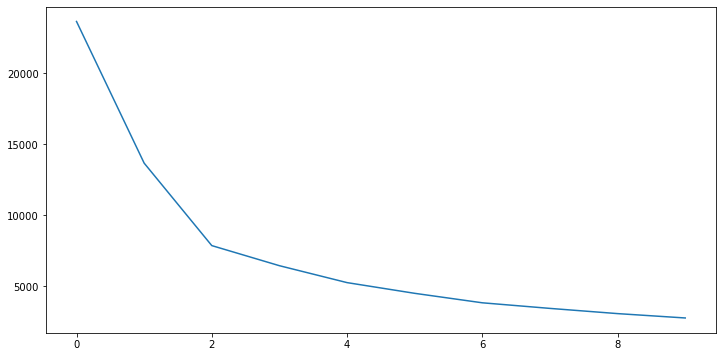

In [43]:
inertia = []

for i in range(1,11):
    kmeans = KMeans(n_clusters = i,
                   init = "k-means++",
                   max_iter = 300,
                   n_init = 10,
                   random_state = 0)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize = (12,6))
plt.plot(inertia)

plt.savefig("Internal Evaluation of K-Mean.png")

**With `K-Means` we get the optimal number of clusters are 3 as the segmentationn. We will use this number (called as `k`) to build the model**

In [26]:
kmeans = KMeans(n_clusters = 3,
               init = "k-means++",
               max_iter = 300,
               n_init = 10,
               random_state = 0)
kmeans.fit(X_std)

KMeans(n_clusters=3, random_state=0)

In [27]:
cluster_labels = kmeans.labels_
print("Assigned cluster labels: \n", cluster_labels)

Assigned cluster labels: 
 [1 1 1 ... 0 2 2]


In [28]:
centroids = kmeans.cluster_centers_
print("Location of Centroids: ")
print(centroids)

Location of Centroids: 
[[ 2.10585297 -0.9278853  -0.89189372]
 [-0.28313201  0.81982225  0.84443274]
 [-0.25710187 -0.70935748 -0.74860646]]


In [29]:
centroids[:,0]

array([ 2.10585297, -0.28313201, -0.25710187])

In [30]:
X_std['clusters'] = cluster_labels

In [31]:
X_std.head()

,recency,frequency,monetary,clusters
0,0.356794,1.320297,0.982774,1
1,-0.931619,1.512872,1.163109,1
2,-0.697362,0.935146,1.006390,1
3,-0.041443,0.357420,0.540524,1
4,-0.861342,1.127722,1.564569,1


**Visualize to see the relation between features with scatterplot for every 2 different features**

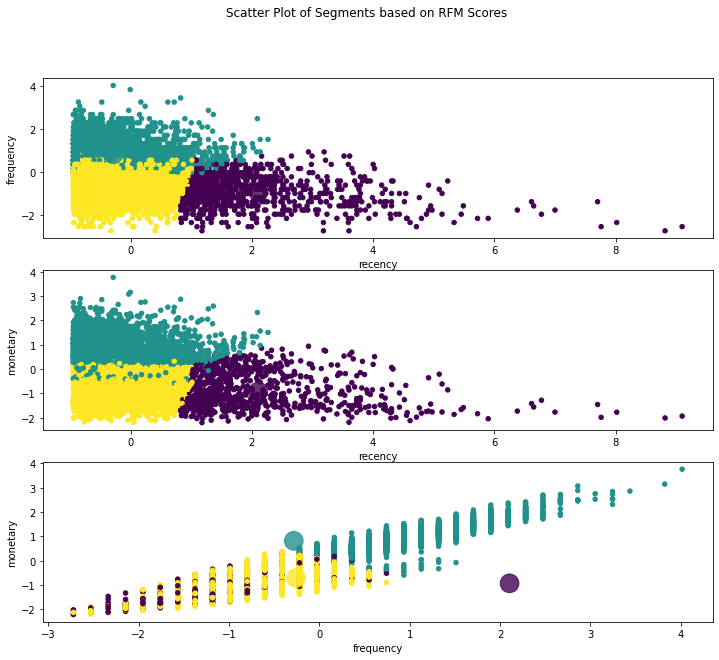

In [32]:
fig, (ax0, ax1, ax2) = plt.subplots(3);
fig.suptitle("Scatter Plot of Segments based on RFM Scores");

k=3

X_std.plot.scatter(x = 'recency',
                   y = 'frequency',
                   c = X_std['clusters'],
                   colormap = "viridis",
                   ax = ax0,
                   colorbar = False,
                   figsize = (12,10)
                  );
ax0.scatter(centroids[:,0], centroids[:,1], marker="o", s=350, alpha=0.8,
            c=range(0,k), cmap="viridis"
           );

X_std.plot.scatter(x = 'recency',
                   y = 'monetary',
                   c = X_std['clusters'],
                   colormap = "viridis",
                   ax = ax1,
                   colorbar = False,
                   figsize = (12,10)
                  );
ax1.scatter(centroids[:,0], centroids[:,1], marker="o", s=350, alpha=0.8,
            c=range(0,k), cmap="viridis"
           );


X_std.plot.scatter(x = 'frequency',
                   y = 'monetary',
                   c = X_std['clusters'],
                   colormap = "viridis",
                   ax = ax2,
                   colorbar = False,
                   figsize = (12,10)
                  );
ax2.scatter(centroids[:,0], centroids[:,1], marker="o", s=350, alpha=0.8,
            c=range(0,k), cmap="viridis"
           );


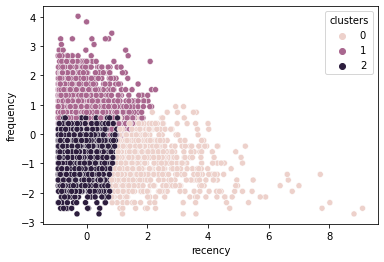

In [44]:
sns.scatterplot(data=X_std, x='recency', y='frequency', hue='clusters')

plt.savefig("Segmentation with K-Means.png")

**We get clearly 3 segmentations**

In [34]:
drfm['cluster'] = cluster_labels
drfm.cluster.unique()

array([1, 0, 2])

In [35]:
drfm['cust_segmentation'] = cluster_labels
drfm['cust_segmentation'].replace({
    0: "Bronze",
    2: "Silver",
    1: "Gold"
}, inplace=True)

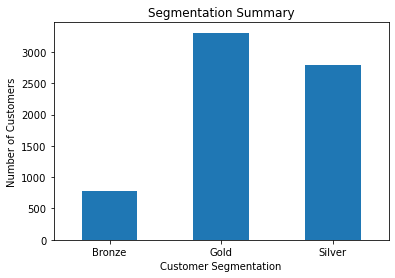

In [47]:
drfm.groupby("cust_segmentation").cluster.count().plot.bar()
plt.xlabel("Customer Segmentation")
plt.xticks(rotation=0)
plt.ylabel("Number of Customers")
plt.title("Segmentation Summary")

plt.savefig("Segmentation Summary.png")

# Agglomerative

In [49]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters = 3)
ac_class = ac.fit(X_std)

print(ac_class)

[0 0 0 ... 2 1 1]


AgglomerativeClustering(n_clusters=3)


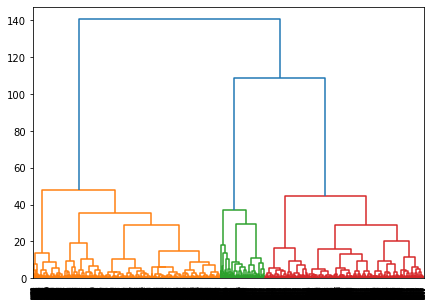

<Figure size 432x288 with 0 Axes>

In [51]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

ac = AgglomerativeClustering(n_clusters = 3)
ac_class = ac.fit(X_std)

print(ac_class)

plt.figure(figsize=(7,5))
dend = sch.dendrogram(sch.linkage(X_std, method='ward'))
plt.show()

plt.savefig("Number of Clusters based on Dendograms.png")

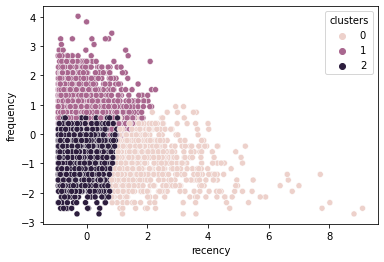

In [46]:
sns.scatterplot(data=X_std,
               x = 'recency',
               y ='frequency',
               hue = 'clusters')

plt.savefig("Segmentation with Agglomerative.png")

<AxesSubplot:xlabel='features', ylabel='value'>

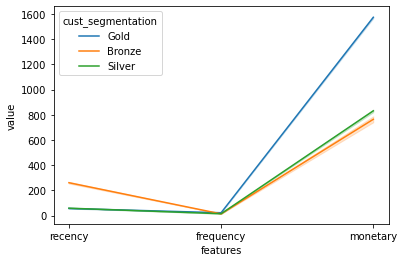

In [39]:
drfm_melted = pd.melt(
    drfm.reset_index(),
    id_vars = 'cust_segmentation',
    value_vars = ["recency", "frequency", "monetary"],
    var_name = ['features'],
    value_name = "value"
)

sns.lineplot('features', 'value', hue='cust_segmentation', data = drfm_melted)

**Use `pandas.melt` to unpivot the `drfm` dataframe for lineplot purpose, to see the different between RFM features**

# Summary

1. With `K-Means` we get the optimal number of clusters are 3, and means to be there will be 3 segmentations from the data. I called this segementation as below:
    * **Bronze for lower segmentation (clluster 0)**<br>
        High recency, low frquency, high monetary
    * **Silver for middle segmentation (clluster 1)**<br>
        low recency, low frequency, high monetary
    * **Gold for higher segmentation (clluster 2)**<br>
        low recency, low frequency, higher monetary
<br>
<br>
2. Actions may be taken:
    * **Bronze**<br>
        -> take a look if there are any issues around the product/service<br>
        -> engage them with related promotion cupon based on the previous transaction
    * **Silver**<br>
        -> give them more related promotion cupon to improve their transactions amount so eventually they become gold customers
    * **Gold**<br>
        -> give them any rewards as their loyalty to deal their transactions on the service